### 강의에서 소개된 파이썬 주요 기능
- statsmodels.formula.api.glm: https://www.statsmodels.org/dev/generated/statsmodels.formula.api.glm.html
- statsmodels.genmod.generalized_linear_model.GLM: https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLM.html
- statsmodels.genmod.generalized_linear_model.GLM.fit: https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLM.fit.html
- statsmodels.genmod.families.family.Binomial: https://www.statsmodels.org/dev/generated/statsmodels.genmod.families.family.Binomial.html
- numpy.exp: https://numpy.org/doc/stable/reference/generated/numpy.exp.html
- numpy.zeros: https://numpy.org/doc/stable/reference/generated/numpy.zeros.html

### 슈팅 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from src.plot_utils import draw_pitch

In [2]:
shots = pd.read_pickle('data/shots.pkl')
feature_cols = ['x', 'y', 'distance', 'angle', 'freekick', 'header', 'goal']
shot_features = shots[feature_cols]
shot_features

,x,y,distance,angle,freekick,header,goal
0,12.48,6.12,13.899813,26.933236,0,0,1
1,15.60,-1.36,15.659170,26.224941,0,0,0
2,4.16,-1.36,4.376665,79.289489,0,1,1
3,19.76,11.56,22.893038,15.813597,0,0,0
4,26.00,13.60,29.342120,12.655803,0,0,0
...,...,...,...,...,...,...,...
45940,8.32,-2.04,8.566446,45.433179,0,0,1
45941,36.40,-7.48,37.160603,11.025434,0,0,0
45942,19.76,11.56,22.893038,15.813597,0,0,0
45943,22.88,-17.68,28.914993,11.507036,0,0,0


### 단일 변수 로지스틱 회귀 기반 xG 산출

##### (1) 슈팅 각도 기반 xG 모델 학습

- 슈팅 각도에 따른 득점 여부 시각화

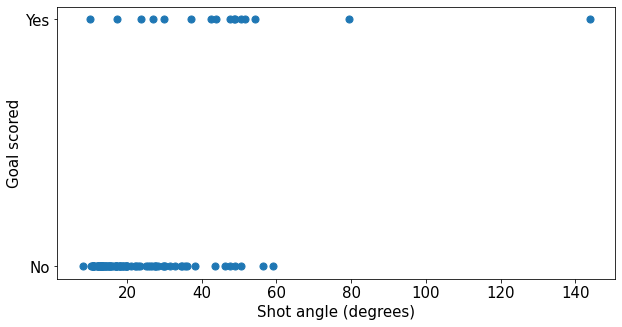

In [3]:
plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})

angles = shot_features[:100]['angle']
goals = shot_features[:100]['goal']
plt.scatter(angles, goals, s=50)

plt.xlabel("Shot angle (degrees)")
plt.ylabel('Goal scored')

plt.yticks([0, 1], labels=['No', 'Yes'])
plt.show()

- 슈팅 각도 구간별 득점 확률 산출

In [4]:
bins = np.arange(0, 180, 3)
angle_cats = pd.cut(shot_features['angle'], bins, right=False)
probs_per_angle = shot_features.groupby(angle_cats)['goal'].mean()
probs_per_angle

angle
[0, 3)        0.000000
[3, 6)        0.103774
[6, 9)        0.046703
[9, 12)       0.020686
[12, 15)      0.033602
[15, 18)      0.048739
[18, 21)      0.072339
[21, 24)      0.106334
[24, 27)      0.127551
[27, 30)      0.144830
[30, 33)      0.138327
[33, 36)      0.270157
[36, 39)      0.286483
[39, 42)      0.204023
[42, 45)      0.243517
[45, 48)      0.244898
[48, 51)      0.324324
[51, 54)      0.288770
[54, 57)      0.292308
[57, 60)      0.327434
[60, 63)      0.329861
[63, 66)      0.435583
[66, 69)      0.328767
[69, 72)      0.514768
[72, 75)           NaN
[75, 78)      0.583333
[78, 81)      0.519380
[81, 84)      0.530973
[84, 87)           NaN
[87, 90)      0.562500
[90, 93)           NaN
[93, 96)      0.666667
[96, 99)      0.683333
[99, 102)     0.750000
[102, 105)         NaN
[105, 108)    0.730769
[108, 111)         NaN
[111, 114)         NaN
[114, 117)    0.791667
[117, 120)    0.565217
[120, 123)    0.631579
[123, 126)         NaN
[126, 129)         NaN
[129,

- 슈팅 각도 구간별 득점 확률 시각화

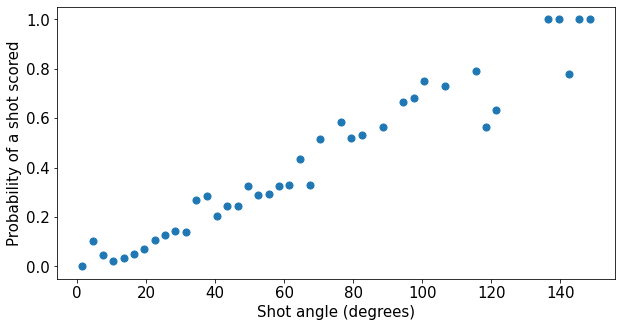

In [5]:
plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.scatter(bins[:-1] + 1.5, probs_per_angle.values, s=50)

plt.xlabel("Shot angle (degrees)")
plt.ylabel('Probability of a shot scored')
plt.show()

- 슈팅 각도와 득점 여부 간 로지스틱 회귀 모델 학습

In [6]:
xg_angle_fit = smf.glm(formula='goal ~ angle', data=shot_features, family=sm.families.Binomial()).fit()
xg_angle_fit.params

Intercept   -3.553267
angle        0.053492
dtype: float64

- 슈팅 각도 구간별 득점 확률 및 xG 비교

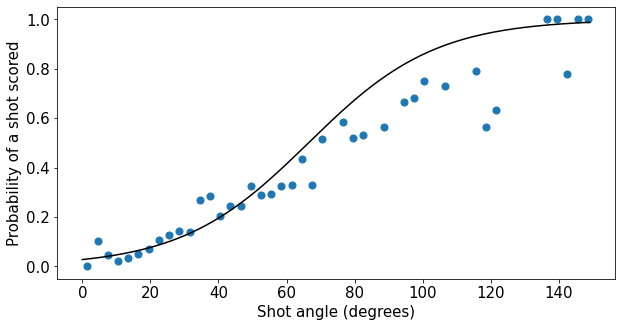

In [7]:
plt.figure(figsize=(10, 5))
plt.scatter(bins[:-1] + 1.5, probs_per_angle.values, s=50)

a, b = xg_angle_fit.params
x = np.arange(0, 150)
y = 1 / (1 + np.exp(-a - b * x))
plt.plot(x, y, c='black')

plt.xlabel("Shot angle (degrees)")
plt.ylabel('Probability of a shot scored')
plt.show()

##### (2) 슈팅 거리 기반 xG 모델 학습

- 슈팅 거리 구간별 득점 확률 산출

In [8]:
bins = np.arange(0, 50, 1) + 1
dist_cats = pd.cut(shot_features['distance'], bins, right=False)
probs_per_dist = shot_features.groupby(dist_cats)['goal'].mean()
probs_per_dist

distance
[1, 2)      0.923077
[2, 3)      0.710000
[3, 4)      0.630769
[4, 5)      0.552311
[5, 6)      0.400998
[6, 7)      0.296519
[7, 8)      0.267745
[8, 9)      0.231275
[9, 10)     0.191076
[10, 11)    0.236790
[11, 12)    0.218467
[12, 13)    0.132162
[13, 14)    0.121698
[14, 15)    0.111020
[15, 16)    0.109316
[16, 17)    0.079202
[17, 18)    0.080117
[18, 19)    0.070676
[19, 20)    0.047238
[20, 21)    0.046901
[21, 22)    0.044577
[22, 23)    0.034559
[23, 24)    0.050145
[24, 25)    0.034182
[25, 26)    0.032131
[26, 27)    0.030928
[27, 28)    0.024473
[28, 29)    0.028534
[29, 30)    0.027397
[30, 31)    0.015018
[31, 32)    0.020170
[32, 33)    0.025424
[33, 34)    0.020202
[34, 35)    0.006154
[35, 36)    0.004292
[36, 37)    0.029240
[37, 38)    0.023810
[38, 39)    0.000000
[39, 40)    0.063830
[40, 41)    0.000000
[41, 42)    0.000000
[42, 43)    0.052632
[43, 44)    0.000000
[44, 45)    0.071429
[45, 46)    0.076923
[46, 47)    0.100000
[47, 48)    0.000000
[48,

- 슈팅 거리 구간별 득점 확률 시각화

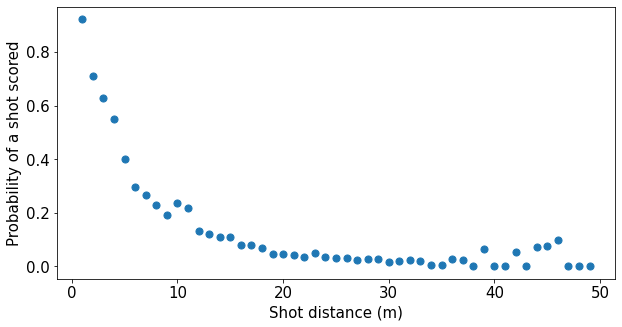

In [9]:
plt.figure(figsize=(10, 5))
plt.scatter(bins[:-1], probs_per_dist.values, s=50)

plt.xlabel("Shot distance (m)")
plt.ylabel('Probability of a shot scored')
plt.show()

- 슈팅 거리와 득점 여부 간 로지스틱 회귀 모델 학습

In [10]:
xg_dist_fit = smf.glm(formula='goal ~ distance', data=shot_features, family=sm.families.Binomial()).fit()
xg_dist_fit.params

Intercept    0.075741
distance    -0.136982
dtype: float64

- 슈팅 거리 구간별 득점 확률 및 xG 비교

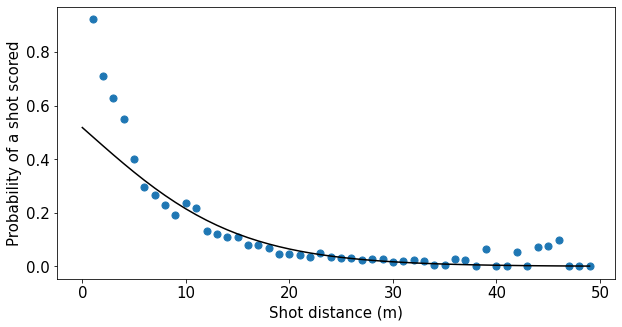

In [11]:
plt.figure(figsize=(10, 5))
plt.scatter(bins[:-1], probs_per_dist.values, s=50)

a, b = xg_dist_fit.params
x = np.arange(0, 50, 1)
y = 1 / (1 + np.exp(-a - b * x))
plt.plot(x, y, c='black')

plt.xlabel("Shot distance (m)")
plt.ylabel('Probability of a shot scored')
plt.show()

### 다중 변수 로지스틱 회귀 기반 최종 xG 산출

##### (1) 로지스틱 회귀 모델 학습

In [12]:
formula = 'goal ~ x + y + distance + angle + freekick + header'
xg_fit = smf.glm(formula=formula, data=shot_features, family=sm.families.Binomial()).fit()
print(xg_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   goal   No. Observations:                45945
Model:                            GLM   Df Residuals:                    45938
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13243.
Date:                Thu, 21 Dec 2023   Deviance:                       26487.
Time:                        13:15:56   Pearson chi2:                 9.66e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9186      0.113     -8.094      0.0

In [13]:
print(f'''Goal probability = sigmoid(
    {xg_fit.params[0]:.4f} +
     {xg_fit.params[1]:.4f} * x + 
     {xg_fit.params[2]:.4f} * y +
    {xg_fit.params[3]:.4f} * distance +
     {xg_fit.params[4]:.4f} * angle +
     {xg_fit.params[5]:.4f} * freekick +
    {xg_fit.params[6]:.4f} * header
)''')

Goal probability = sigmoid(
    -0.9186 +
     0.0283 * x + 
     0.0034 * y +
    -0.1404 * distance +
     0.0265 * angle +
     1.5535 * freekick +
    -1.0303 * header
)


##### (2) 학습된 모델 기반 슈팅별 xG 산출

In [14]:
sum = xg_fit.params[0]
for i, c in enumerate(shot_features.columns[:6]):
    sum += xg_fit.params[i+1] * shot_features[c]

shot_features['xg'] = 1 / (1 + np.exp(-sum))
shot_features

,x,y,distance,angle,freekick,header,goal,xg
0,12.48,6.12,13.899813,26.933236,0,0,1,0.143848
1,15.60,-1.36,15.659170,26.224941,0,0,0,0.120612
2,4.16,-1.36,4.376665,79.289489,0,1,1,0.412967
3,19.76,11.56,22.893038,15.813597,0,0,0,0.042434
4,26.00,13.60,29.342120,12.655803,0,0,0,0.019414
...,...,...,...,...,...,...,...,...
45940,8.32,-2.04,8.566446,45.433179,0,0,1,0.333921
45941,36.40,-7.48,37.160603,11.025434,0,0,0,0.007840
45942,19.76,11.56,22.893038,15.813597,0,0,0,0.042434
45943,22.88,-17.68,28.914993,11.507036,0,0,0,0.016508


In [15]:
shots = pd.concat([shots, shot_features[['xg']]], axis=1)
shots.to_pickle('data/shots.pkl')

##### (3) 1m x 1m 구역별 xG 산출

In [16]:
feature_cols

['x', 'y', 'distance', 'angle', 'freekick', 'header', 'goal']

In [17]:
shot_grid = []
m = 50
n = 64

for x_idx in range(m):
    for y_idx in range(n):
        x = (x_idx + 0.5) * 52 / m
        y = (y_idx + 0.5) * 68 / n - 34
        shot_grid.append({'x_idx': x_idx, 'y_idx': y_idx, 'x': x, 'y': y})

shot_grid = pd.DataFrame(shot_grid)
shot_grid['distance'] = shot_grid[['x', 'y']].apply(np.linalg.norm, axis=1)

x = shot_grid['x']
y = shot_grid['y']
goal_width = 7.32
angles = np.arctan((goal_width * x) / (x ** 2 + y ** 2 - (goal_width / 2) ** 2))
shot_grid['angle'] = np.where(angles >= 0, angles, angles + np.pi) * 180 / np.pi

shot_grid['freekick'] = 0
shot_grid['header'] = 0

sum = xg_fit.params[0]
for i, c in enumerate(feature_cols[:-1]):
    sum += xg_fit.params[i+1] * shot_grid[c]

shot_grid['xg'] = 1 / (1 + np.exp(-sum))
shot_grid

,x_idx,y_idx,x,y,distance,angle,freekick,header,xg
0,0,0,0.52,-33.46875,33.472789,0.197004,0,0,0.003291
1,0,1,0.52,-32.40625,32.410422,0.210300,0,0,0.003833
2,0,2,0.52,-31.34375,31.348063,0.224996,0,0,0.004465
3,0,3,0.52,-30.28125,30.285714,0.241295,0,0,0.005201
4,0,4,0.52,-29.21875,29.223377,0.259442,0,0,0.006057
...,...,...,...,...,...,...,...,...,...
3195,49,59,51.48,29.21875,59.193967,6.161722,0,0,0.000546
3196,49,60,51.48,30.28125,59.725577,6.052930,0,0,0.000507
3197,49,61,51.48,31.34375,60.271229,5.944216,0,0,0.000470
3198,49,62,51.48,32.40625,60.830547,5.835773,0,0,0.000435


In [18]:
xg_heatmap = np.zeros((m, n))

for i in shot_grid.index:
    x_idx = shot_grid.at[i, 'x_idx']
    y_idx = shot_grid.at[i, 'y_idx']
    xg_heatmap[x_idx, y_idx] = shot_grid.at[i, 'xg']

    # x = int(shot_grid.at[i, 'x'] - 0.5)
    # y = int(shot_grid.at[i, 'y'] + 33.5)
    # xg_heatmap[x, y] = shot_grid.at[i, 'xg']

xg_heatmap

array([[0.00329082, 0.0038334 , 0.00446521, ..., 0.00552042, 0.00477423,
        0.00412864],
       [0.00340865, 0.00397277, 0.00463027, ..., 0.00572426, 0.00494763,
        0.00427634],
       [0.00351449, 0.00409765, 0.00477782, ..., 0.00590646, 0.005103  ,
        0.00440901],
       ...,
       [0.00038573, 0.00042181, 0.00046042, ..., 0.00056976, 0.00052578,
        0.00048429],
       [0.00035145, 0.00038383, 0.00041841, ..., 0.00051779, 0.00047844,
        0.00044126],
       [0.00031996, 0.000349  , 0.00037996, ..., 0.00047021, 0.00043503,
        0.00040173]])

##### (4) xG 히트맵 시각화

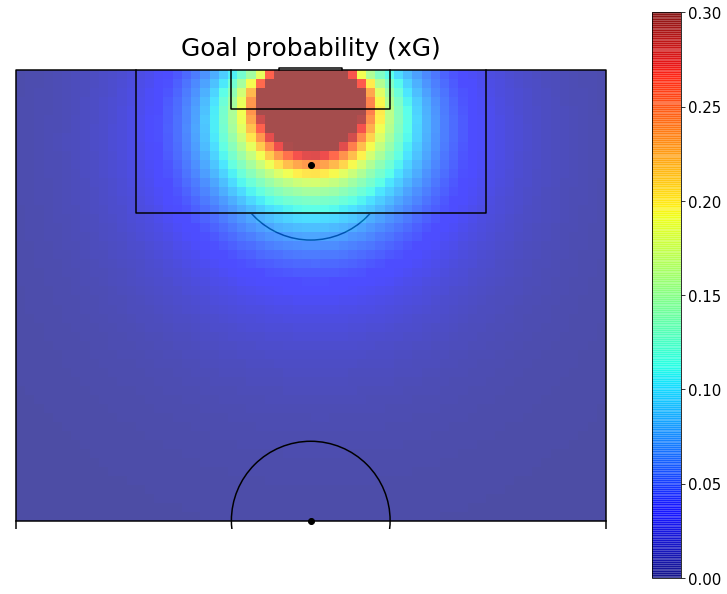

In [19]:
fig, ax = draw_pitch(pitch='white', line='black', orientation='v', view='h')

img = ax.imshow(xg_heatmap, extent=[0, 68, 52, 104], vmin=0, vmax=0.3, cmap='jet', alpha=0.7)
fig.colorbar(img, ax=ax)
plt.title('Goal probability (xG)', fontdict={'size': 25})

plt.show()

In [20]:
pd.DataFrame(xg_heatmap).to_csv('data/xg_heatmap.csv', index=False)